# Assignment
In this course assignment you must build a predictive model to determine what place a runner will come in in a foot race. More specifically, you must predict the place order for all participants running races in the year 2019 which are part of a series (e.g. they have been run annually, or at least once previously) using historical data. **For each race you must predict the integer place ordering for all participants**. You are not predicting the top n finishers, or performance bands where people will finish. Instead, your method is expected to be integrated into a premium feature of an application such as Strava, where historical data and data about the racer (and who is signed up for the race!) could be used to help build a personalized prediction for them.

## Framing
Through this assignment you will demonstrate your ability to build sophisticated supervised machine learning models, from data manipulation through feature engineering and modelling. This is an authentic dataset, and a real-world problem. You can use whatever modelling method you would like to, and can characterise the problem as a regression, classification, or ordinal prediction problem. There is no particular guidelines you must follow, nor guidance offered in the course _per se_ however, there is plenty of opportunity to ask course staff questions. **It is expected that this assignment will take significant effort**.

## About the Data
All of the races you are asked to predict outcomes for have a temporal relationship with some race in the past (e.g. they are part of an annual series), and I have included an identifier `sequence_id` to help identify this. The `sequence_id` will be included in all races you need to predict, so you can build race-specific features should you wish to. Races which are in your training set and do not have a `sequence_id` could be used however you might like. There may be some races which have a `sequence_id` in the training set but do not have a `sequence_id` in the holdout set -- this all depends what is offered in a given year!

A couple of core concepts are important beyond sequences. First, races have categories, which generally (though doesn't need to) denote the length of the race (e.g. 5k, marathon, etc). I've cleaned this column into a new one, prepending the word `clean` so that a columns such as `category.completed.name` becomes `clean_category.completed.name`. I have left the original data in there for you as well, and the transformations I've done have been largely to reduce dimensionality along lines I think is reasonable.

In addition to a category, there are `brackets`. Brackets typical denote demographic aspects of the runners and group them, such as Men aged 40-45. I have removed bracket information from the data and instead want you to focus on overall prediction which merges all runners in a given category together. This (should) line up with the rank order based on the individual's time, though I have not verified it (and predicting time is **not** the task).

## Evaluation Criteria
In this assignment you will be penalized equally for incorrect predictions weighted by the distance by which you are incorrect within a given race. It does not matter whether you over or under predicted a given rank, you are penalized one point per position you are off for a given individual. All DNF's are removed from the dataset, so each person in the dataset has a rank. You *must* provide a predicted rank for each person however, you may rank multiple people at the same spot if you would like (e.g. ties). The evaluation is for each combination of event and category, so a given event may have a 5 kilometer category, a 1 mile category, and so forth. Only individuals registered for a given event and category combination are included in the `DataFrame` you will be asked to predict for. Each event/category pair is equally weighted, and is scaled by the size of the event. Your overall prediction score will be the sum of all scores across the prediction tasks (e.g. across unique combinations of event and category). The exact scoring function is provided below.

## Example Solution
The following cell contains an example solution to demonstrate the API which is used for this assignment. In short, you are to create an `sklearn.pipeline.Pipeline` object which you `fit()` on your training data using whatever method you like and serialize it to disk in a file called `pipeline.cloudpickle`. This object will then be reinstantiated in the autograder and evaluated based on the scoring function described above. Please note that the solution below would be a poor one, it is intended **only** to demonstrate the API for submission.

In [4]:
import pandas as pd
import numpy as np
import cloudpickle
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer

# This is a custom transformer to demonstrate how you might modify the data for feature
# selection or engineering before applying a given model. In this example I am only
# doing feature selection, and passing to the next element in the pipeline the age
# and bib number for the runner. Thus only two features will be used in my predictive model.
# There are other ways to do this
class CustomTransformer(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def fit(self, X, y = None):
        return self
    def transform(self, X, y=None):
        # Just select the features we want
        Xprime=X[['age','bib']]
        # Ensure that they have numbers in them of the regression will fail
        Xprime=Xprime.fillna(value=-1)
        return Xprime

# I build a very basic pipeline which is made up of three stages. In the first, my
# custom transform is called and reduces the DataFrame to just two columns. In the
# second I use a built-in transformer from sklearn to bucket users based on their
# bib number, perhaps as a proxy for "how early did they sign up". In the final step
# I want to use a LinearRegression() regressor.

# There are two main concerns I need to address. First, I need to be resilient to bad
# data which might address. So I know the LinearRegression() object can't handle
# missing data, so I need to deal with that. This was done in the CustomeTransformer()
# already.

# Second, I actually need to be ranking results, not regressing. Depending upon your
# model you need to consider this carefully. Here is a fine catch all if you
# are using regression, and object which just ranks the results in order. This is
# called monkey patching and replaces the LinearRegression() object's predict()
# function with a wrapper
reg=LinearRegression()
reg.original_predict=reg.predict

def new_predict(X):
    # run the old regression method
    rankings=reg.original_predict(X)
    # now calculate and return the ranks of each item instead
    # we need to add a +1 because the lowest rank is a 1, not a 0
    # it's unfortunate, the first athletic competition was probably run by R users...
    return rankings.squeeze().argsort()+1

# Now we overwrite (monkey patch) the predict() function with our own implementation
reg.predict=new_predict

# And build our pipeline object
pipe = make_pipeline( CustomTransformer(), QuantileTransformer(), reg )

# This is just one way to do this, you could also implement a new estimator with the
# predict interface and build all of your logic in there. The benefit of the
# pipeline is that you can rapidly change the logic and try different pipelines using
# common methods from sklearn. When the pipeline gets complicated, you can also
# visualize it...

from sklearn import set_config
set_config(display="diagram")
display(pipe)

# Once the pipeline is built, we need to train it. I'm going to just do a pretty poor
# job here, getting the training set provided
df=pd.read_csv("../../assets/assignment/df_train.csv.gz")

# I'm just going to build a model off of one event/category combination (lame)
training_data=df.query("`event.id`=='583f013a-1e54-4906-87f7-2b625206f5f9' and `clean_categories.name`=='5k'")

# And I'm going to pass in all of my potential columns for consideration. Note: The
# example pipeline I built is going to reduce this to just the two columns I'm interested
# in, so this is a safe thing to do. But be aware, the holdout set does not have all of
# the data the training set might, because of leakage, so you need to think about this
# and not make assumptions. You can see how I built the holdout set at the bottom of
# this notebook
X=set(training_data.columns)-{'overall_ranking'}

# The ranking is what we aim to predict
y={'overall_ranking'}

# Now I fit() the pipeline. You'll note that the outcomes I need to squeeze() to ensure
# it's a one dimensional structure and not a DataFrame
fitted_pipe=pipe.fit(training_data[X],training_data[y].squeeze().to_numpy())

# And now, assuming that I am happy with this model and think it is great, I write the
# fitted pipeline to a file. This file will be read in by the autograder.
cloudpickle.dump(fitted_pipe, open('pipeline.cloudpickle','wb'))

Pipeline(steps=[('customtransformer', CustomTransformer()),
                ('quantiletransformer', QuantileTransformer()),
                ('linearregression', LinearRegression())])

In [ ]:
#########################################################
#######        NOTES     ################################

#Features:
# -last race (yr)
# -participants expected
# -category type (one hot?)*label encoding
# -age
# -event month
# -(event year - last race year) time since last race
# -state (one-hot?) *label encoding
# -distance column

## Testing the Solution
With a minimum pipeline built we can think about testing it. The code below simulates the autograder, and is something you can use to evaluate how your model performs. The most important function is the `score()` function, which demonstrates how the score of the model fitness will be determined, as described previously. This function just compares two ranked lists and determined how aligned they are with one another. The second function is the `evaluate()` function, which runs your model over a given race of data. Note that the evaluation generates new ranks from the `overall_ranking` but doesn't use those numbers directly. Those numbers are in-order, but due to underlying data assumptions may have gaps.

0.3331551776296302


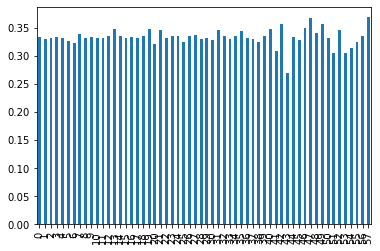

In [2]:
import pandas as pd
import numpy as np
import cloudpickle
import sklearn

# This code simulates the autograder. It is not the full autograder implementation
# but shares an API with the autograder. It expects that your fitted pipeline is
# submitted with the name pipeline.cloudpickle as demonstrated above. This object
# must implement the predict() function. This is done automatically by the sklearn
# Pipeline object if the last element of your pipeline is a classifier which has
# a predict() function. If you are not submitting a Pipeline, and want to do something
# different, you *must* have a predict() function of the same method signature, e.g.:
#
#   predict(self, X, **predict_params)->np.ndarray

# Load holdout data, in this case I'll simulate it by loading the training data
df=pd.read_csv("../../assets/assignment/df_train.csv.gz")

# And evaluate on all 5k races that we didn't consider for training
holdout_data=df.query("`event.id`!='583f013a-1e54-4906-87f7-2b625206f5f9' and `clean_categories.name`=='5k'")


# This is the scoring function to determine model fitness
def score(left: pd.DataFrame, right: pd.DataFrame):
    '''
    Calculates the difference between the left and the right when considering rank of items. 
    This scoring function requires that the two DataFrames have identical indicies, and that
    they each contain only one column of values and no missing values. Props to Blake Atkinson
    for providing MWE indicating issues with autograder version #1.
    '''
    assert(type(left)==pd.DataFrame)
    assert(type(right)==pd.DataFrame)
    assert(len(left)==len(right))
    assert(not np.any(np.isnan(left)))
    assert(not np.any(np.isnan(right)))
    assert(left.index.equals(right.index))
    # convert to ndarrays
    left=left.squeeze()
    right=right.squeeze()
    return np.sum(np.abs(left-right))/(len(left)*(len(left)-1))

# This function runs the prediction model agains a given event/category pair. It
# intentionally loads the student model each time to avoid accidental leakage of data
# between events.
def evaluate(data, pipeline_file='pipeline.cloudpickle'):
    # Load student pipeline
    fitted_pipe = cloudpickle.load(open(pipeline_file,'rb'))
    
    # Separate out the X and y
    X=list(set(data.columns)-{'overall_ranking'})
    y=['overall_ranking']
    
    # Drop any missing results (DNFs)
    data=data.dropna(subset=['overall_ranking'])
    
    # Ensure there is data to actually predict on
    if len(data)==0:
        return np.nan

    # Predict on unseen data
    predictions=pd.DataFrame(fitted_pipe.predict(data[X]),data.index)
    observed=data[y]
    
    # Generate rankings within this bracket
    observed=pd.DataFrame(data[y].rank(),data.index)
    
    # Return the ratio of the student score
    return pd.Series({"score":score(observed,predictions)})

# Student solution
pipeline_file='pipeline.cloudpickle'

# Run prediction on each group
results=holdout_data.groupby(["event.id","clean_categories.name"]).apply(evaluate, pipeline_file)

# Display the results, uncomment this for your own display
results.reset_index()['score'].plot.bar();

# This is the student final grade
print(np.average(results))

In [5]:
df=pd.read_csv("../../assets/assignment/df_train.csv.gz")

# And evaluate on all 5k races that we didn't consider for training
holdout_data=df.query("`event.id`!='583f013a-1e54-4906-87f7-2b625206f5f9' and `clean_categories.name`=='5k'")

holdout_data.shape

(131625, 126)

# Addendum
The following is the code I wrote to clean the data once it had been obtained. This may or may not be useful in helping to explain the structure of the data to you. You should leverage the visual exploration techniques and supervised machine learning techniques to better understand this data. **You do not have to run this file, this file does not do anything as I've already preprocessed the data for you.** The rest of this file is simply to give you a better idea of the task, and the code should demonstrate how I've done some data cleaning.

In [ ]:
import pandas as pd

# All of the runners
df_runners=pd.read_csv("../runners/full_runners.csv")

# All of the races
df_races=pd.read_csv("../processed_historical_races.csv")

# annoying capitalization in category names
df_races["clean_categories.name"]=df_races["categories.name"].dropna().apply(lambda x: x.lower().strip())

# make this change in the runners too
df_runners["clean_category.completed.name"]=df_runners["category.completed.name"].dropna().apply(lambda x: x.lower().strip())
df_runners["clean_category.registered.name"]=df_runners["category.registered.name"].dropna().apply(lambda x: x.lower().strip())

# remove cruft left over from poor scraping
del(df_races["Unnamed: 0"])
del(df_runners["Unnamed: 0"])

# deal with column name conflicts, the id==body.id for a race which had details so lets use the latter as it is unique
df_races['body.id']=df_races['id']
del(df_races['id'])

# Prune away all data not in 2019 or lower
df_runners=df_runners[df_runners['event.date.start']<'2020-01-01']

# Data processing error means some people are in the frame twice, so we need to priune dupe runners
df_runners=df_runners.groupby(["event.id","clean_category.registered.name","registrant_id"]).head(1)

# Create a merged dataframe
df=(df_races.query('`brackets.name` in ["Overall"]').dropna(subset=['clean_categories.name'])
    .merge(df_runners, how='inner',left_on=['body.id','clean_categories.name'],right_on=['event.id','clean_category.registered.name'])
    .reset_index(drop=True)
   )

In [ ]:
# to generate sequences we should do so by looking at the lineage.previous_event.id
import numpy as np

# a sequences starts at a root, which is a race which has an na lineage.previous_event.id
root_ids=df[(df['lineage.previous_event.id'].isna())]['body.id'].dropna().unique()

# place for sequence identifiers
df['sequence_id']=np.nan

# our strategy for labeling sequences is to set sequence_id to the root node's body.id
for root in root_ids:
    nodes=[root]
    while(True):
        # set the sequence_id to whatever the root is
        df.loc[df['body.id'].isin(nodes), 'sequence_id']=root
        # get all of the children for that that root and put them in nodes
        nodes=df.query('`lineage.previous_event.id` in @nodes')['body.id'].dropna().unique()
        # check the base case of no children and break out of loop to go to next sequence
        if len(nodes)==0:
            break

# sanity check, there should be as many sequences as there are roots
assert len(df['sequence_id'].dropna().unique()) == len(root_ids)

In [ ]:
import json

# Create the column we aim to predict, the ranking within a race this is buried in a
# column that looks kind of like json but isn't
# In the end it's unclear that we can completely rely on this, and we need to just
# use this data to generate a ranked list from. This is likely the result of incomplete
# scraping efforts.
def find_rank(lst,name='Overall'):
    # where did this data come from? not json? not pickle?
    lst=json.loads(lst.replace("'",'"'))
    for dct in lst:
        try:
            if dct['name']==name:
                return "".join(filter(str.isdigit, dct['rank']))
        except:
            return np.nan
df['overall_ranking']=df['result.rankings'].apply(find_rank)

In [ ]:
# Now we need to separate out the races from 2019 to put in our holdout set
# First verify that we don't have to worry about multiple races happening in 2019
# like a monthly race or something
assert 1 == df.query('`event.date.start`>"2019-01-01"').groupby(['sequence_id','clean_categories.name']).apply(lambda x: len(x['body.id'].unique())).sort_values(ascending=False).head(1).iloc[0]

# Pull out all of the observations which have a sequence id in the year 2019 and this 
# is our holdout set. This means a given predictive group might be a new category we've 
# never seen before in this race, e.g. a new 5k track for and event that has run many 
# times, or that it might be an old category which we've seen lots of.
df_holdout=df[(df['event.date.start']>='2019-01-01') & (df['sequence_id'].notna())]

# our training set is every race which is not in 2019
df_train=df[df['event.date.start']<'2019-01-01']

# Discard all races in the holdout set which are not in a sequence in our training set,
# as these are new races and we don't expect them to be predicted
df_holdout=df_holdout[df_holdout['sequence_id'].isin(df_train['sequence_id'].dropna().unique())]

# Now, we have to remove all data which wouldn't be known when the gun fires at the
# race from our holdout dataset. We won't remove this from the student datafiles, but
# since they know it's not in the holdout I'm sure they will do the right thing and not
# try and predict on it
df_holdout=df_holdout.drop(
    columns=['time.end',
             'body.results_certificate',
             'event.results_posted',
             'event.results_posted',
             'event.results_certificate',
             'event.photos_available',
             'event.photos_faces',
             'event.photos_social_sharing',
             'event.results_searchable',
             'corral.id',
             'corral.name',
             'corral.wave',
             'corral.time.close',
             'corral.time.start',
             'result.duration.chip',
             'result.duration.pace',
             'result.rankings',
             'result.splits',
             'result.videos',
             'result.finished',
             'result.disqualified',
             'result.duration'])

df_holdout.to_csv("df_holdout.csv.gz",index=False,compression='gzip')
df_train.to_csv("df_train.csv.gz",index=False,compression='gzip')

In [ ]:
# Let's just summarize a few things about the training set:
print(f"There are {len(df_train)} observations in the training data.")
print(f"There are {len(df_train.groupby(['clean_categories.name','sequence_id']).groups)} groups of categories and sequences in the training data.")
print(f"There are {len(df_train['user_id'].unique())} unique users in the training data.")
print(f"There are {len(df_train[df_train['user_id'].isna()])} users without a user id in the training data.")
print(f"There are {len(df_train[df_train['age']==43])} 43 year old runners in the training data.")